In [270]:
# switch off warnings because we are fearless
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# import the code that will make it easier to extract the data and plot
%run ../agam_conservation/cs.py

In [271]:
# to access the Cs directly we need to load the data
conservation = ConservationScore('../data/AgamP4_conservation.h5')

In [ ]:
# and now we can extract the data
conservation.extract('2R:48714400-48714899')

,chromosome,pos,Cs
0,2R,48714400,0.083213
1,2R,48714401,0.083213
2,2R,48714402,0.026533
3,2R,48714403,0.039503
4,2R,48714404,0.223581
...,...,...,...
494,2R,48714894,0.001870
495,2R,48714895,0.002035
496,2R,48714896,0.003313
497,2R,48714897,0.002471


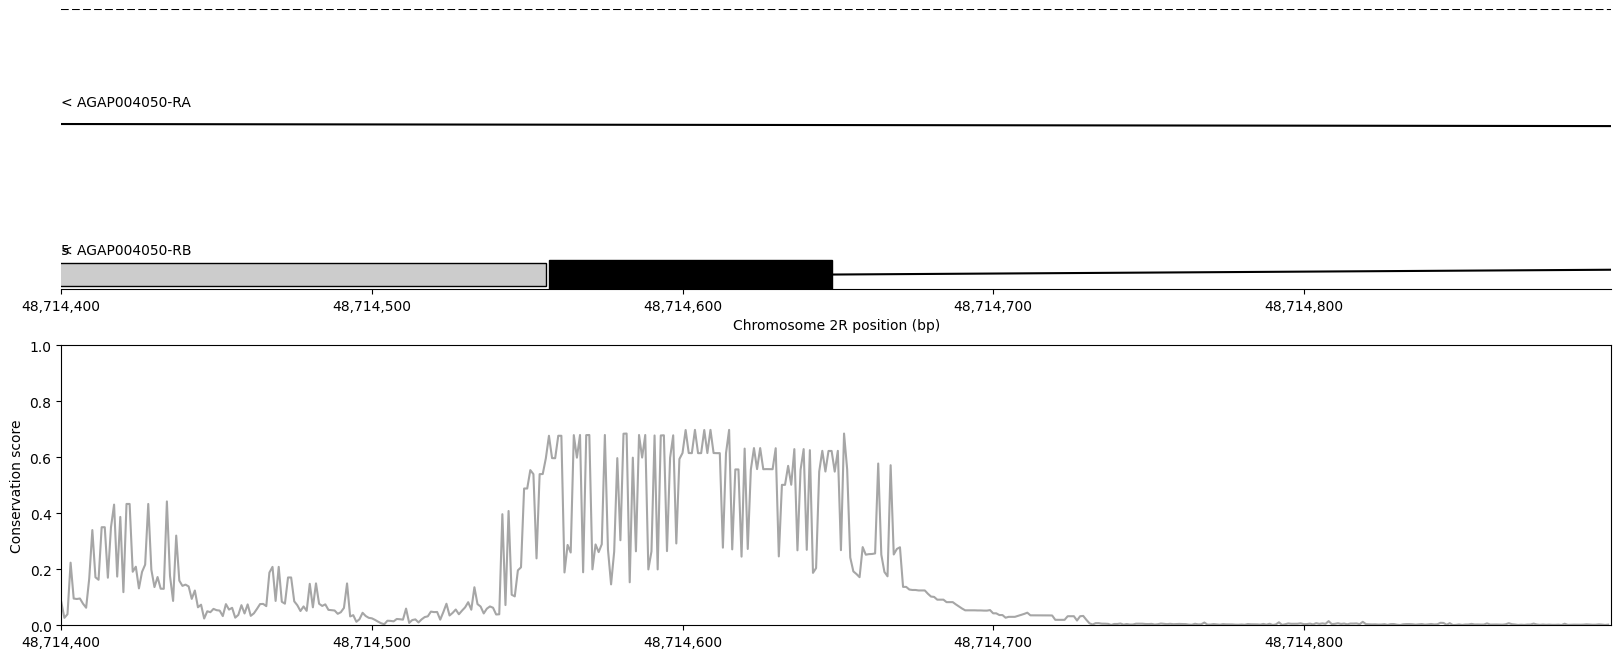

In [ ]:
# we can plot the data for a selected region
conservation.plot('2R:48714400-48714899', include_arrays=['Cs'])

In [275]:
# the data resource is a HDF5 file, which is a hierarchical data format and can be accessed using the h5py library
# it is also possible to extract more data than just the conservation score

# these data are
# - the conservation score
# - the identity matrix
# - the normalized identity matrix
# - AgamP4 SNP density
# - PhyloP scores

# more details can be found in the README file or in the paper

# extracting the identity matrix for a region
start = 48714400
end = 48714899
chromosome = '2R'

# the array name is 'stack', which is the default name for the identity matrix
array = 'stack'

# open the file in read mode
with h5py.File(conservation.data_path, mode='r+') as root:
    # extract the values and row names
    start, end = int(start), int(end)
    # values contains the identity matrix for the region - a numpy array with rows as the species and columns as the positions
    values = root[chromosome][array][:,start-1:end-1]
    # row_names contains the names of the species
    row_names = root[chromosome][array].attrs['rows']

In [276]:
values

array([[ 99.,  99.,  99., ...,  99.,  99.,  99.],
       [100., 100., 100., ..., 100., 100., 100.],
       [100., 100., 100., ..., 100., 100., 100.],
       ...,
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.]],
      shape=(21, 499), dtype=float32)

In [277]:
row_names

array(['AcolM1', 'AaraD1', 'AquaS1', 'AmelC2', 'AmerM2', 'AchrA1',
       'AsinC2', 'AepiE1', 'AminM1', 'AmacM1', 'AculA1', 'AsteI2',
       'AfunF1', 'AatrE3', 'AdirW1', 'AfarF2', 'AdarC3', 'AalbS2',
       'AaegL5', 'CpipJ2', 'DmelP6'], dtype=object)

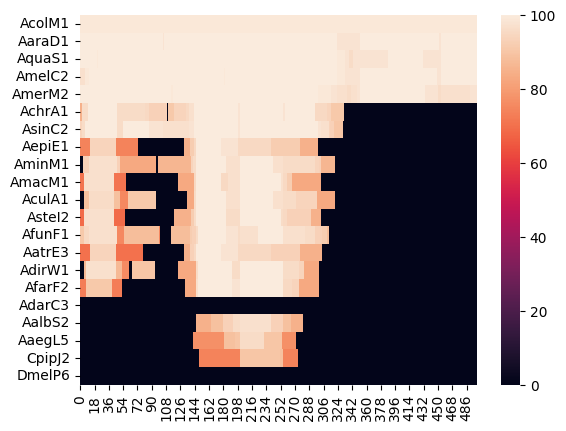

In [278]:
# we can plot the identity matrix as a heatmap
sns.heatmap(values, yticklabels=row_names)
plt.show()

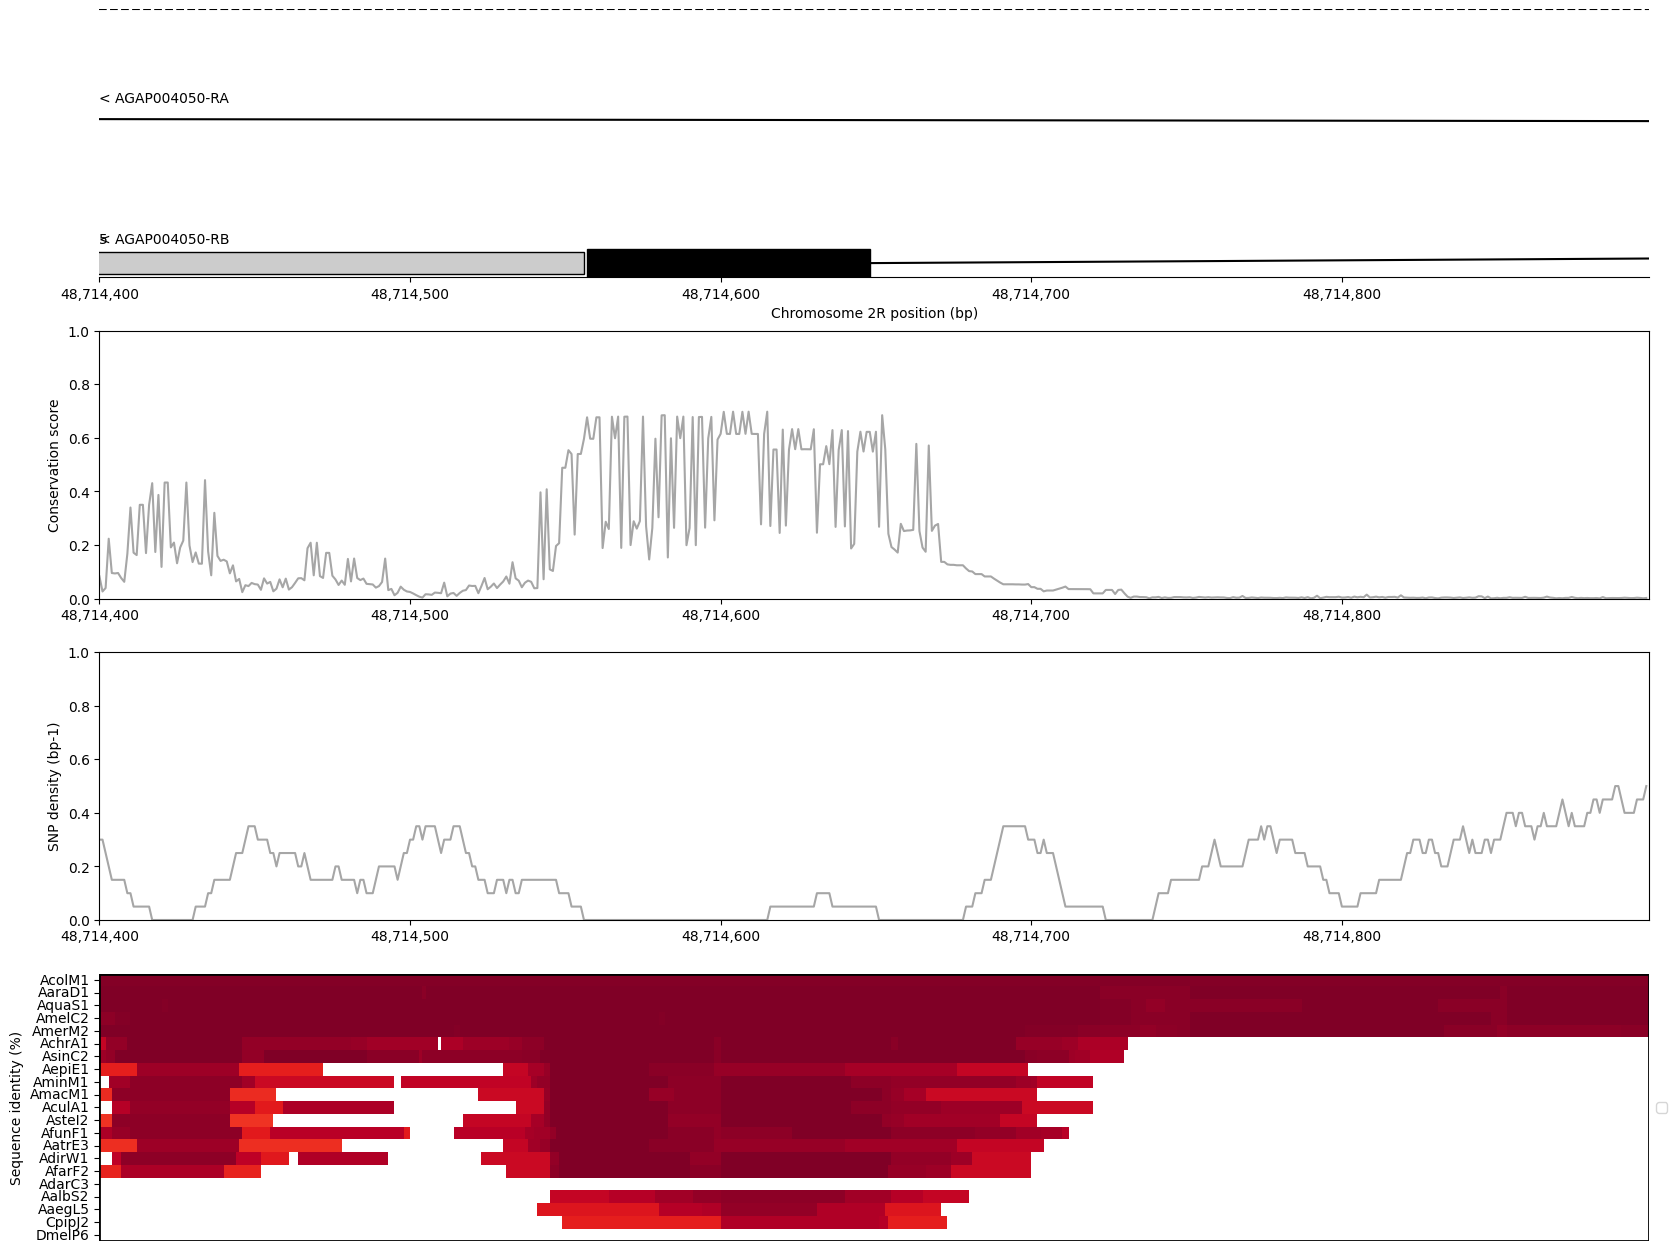

In [ ]:
# or incorporate it into the conservation plot
conservation.plot('2R:48714400-48714899', include_arrays=['Cs', 'snp_density', 'stack'])

# plotting settings can be further tweaked by modifying the plot method in agam_conservation/cs.py

In [283]:
# we can subset the identity array for a subset of species by subsetting the values array
# for example, we can subset the identity values for the Anopheles gambiae complex only

# define the species to include
subset_species = ['AcolM1', 'AaraD1', 'AquaS1', 'AmelC2', 'AmerM2']

# get the indices of the species from the array
indices = [list(row_names).index(species) for species in subset_species]

# subset the values (rows) array
subset_values = values[indices,:]
subset_values

array([[ 99.,  99.,  99., ...,  99.,  99.,  99.],
       [100., 100., 100., ..., 100., 100., 100.],
       [100., 100., 100., ..., 100., 100., 100.],
       [ 97.,  97.,  97., ..., 100., 100., 100.],
       [100., 100., 100., ...,  98.,  98.,  98.]],
      shape=(5, 499), dtype=float32)

In [ ]:
# we can do the same for the normalised identity matrix as well, this time from scratch
# normalised identity matrix is the identity matrix normalised by phylogenetic distance between Anopheles gambie and the other species based on multiple genome alignment
# the normalsation factors can be accesed in data/phyl_distances.tsv

# define the region of interest
start = 48714400
end = 48714899
chromosome = '2R'

# the array name is now going to be 'stack_norm', which is the default name for the normalised identity matrix
array = 'stack_norm'

# open the file in read mode
with h5py.File(conservation.data_path, mode='r+') as root:
    # extract the values and row names
    start, end = int(start), int(end)
    # values contains the identity matrix for the region - a numpy array with rows as the species and columns as the positions
    values = root[chromosome][array][:,start-1:end-1]
    # row_names contains the names of the species
    row_names = root[chromosome][array].attrs['rows']

subset_species = ['AcolM1', 'AaraD1', 'AquaS1', 'AmelC2', 'AmerM2']
indices = [list(row_names).index(species) for species in subset_species]
subset_values = values[indices,:]


In [ ]:
from sklearn import preprocessing

# if we wanto to calculate an alternative conservation score based on the subset of species, we can do the following
# *the author goes back to the paper to check the formula*

# besides the normalised identity matrix that we have in values variable, we also need SNP density and the PhyloP scores
# luckily, we have all the required data in the conservation object (root)

# extract the required arrays
with h5py.File(conservation.data_path, mode='r+') as root:
    start, end = int(start), int(end)
    snp_density = root[chromosome]['snp_density'][0,start-1:end-1]
    phylop = root[chromosome]['phyloP'][0,start-1:end-1]

# now to the calculation
# first we need to get the average of the normalised identity matrix for the subset of species for each position
subset_values_mean = subset_values.sum(axis=0) / len(subset_species)

# then we do incorporate the SNP density
subset_values_mean_snps = subset_values_mean * ((1-snp_density) / (1+snp_density))

# finally we incorporate the PhyloP scores (1/2e^(-phylop))
subset_cs_raw = subset_values_mean_snps * (1/2*np.exp(-phylop))

# we use MinMax scaler to scale a range between 0 and 1, where 1 means high conservation, and 0 means low conservation
subset_cs = preprocessing.MinMaxScaler().fit_transform(subset_cs_raw.reshape(-1,1)).flatten()

# !!! IMPORTANT NOTE !!! 
# unlike the conservation score calculated in the paper, this score is scaled between 0 and 1, only for the selected region and species
# if we wanted to calculate the conservation score for the whole chromosome, we would need omit the start and end positions
# this can take some time and memory so please make sure you have enough resources before running the code

# to wrap things up - if there are any NaN values, we can replace them with 0
subset_cs = np.nan_to_num(subset_cs)

# et voila, we have the conservation score for the subset of species for the region of interest
subset_cs

array([0.07305208, 0.07305208, 0.50441885, 0.5696416 , 0.00178289,
       0.38388753, 0.39900213, 0.38706076, 0.7202605 , 0.7202605 ,
       0.20638764, 0.0336288 , 0.27710328, 0.3275216 , 0.0637605 ,
       0.0637605 , 0.3031079 , 0.0637605 , 0.05681167, 0.3894638 ,
       0.07744901, 0.9978632 , 0.05558612, 0.05583084, 0.3315126 ,
       0.2830198 , 0.61361   , 0.3331069 , 0.26598427, 0.05583084,
       0.3106015 , 0.58109844, 0.2954316 , 0.4727911 , 0.47549328,
       0.02655698, 0.20748216, 0.80613077, 0.02397577, 0.18053761,
       0.228919  , 0.20841178, 0.22685987, 0.40556479, 0.18024546,
       0.5734879 , 0.30766365, 0.5734879 , 0.5078707 , 0.4471139 ,
       0.22232041, 0.24698302, 0.5078707 , 0.5078707 , 0.14898956,
       0.26497597, 0.31255668, 0.5734879 , 0.6445732 , 0.1719186 ,
       0.5734879 , 0.16673546, 0.5734879 , 0.364288  , 0.20444533,
       0.23876685, 0.23542973, 0.2071662 , 0.01578101, 0.02470073,
       0.25542977, 0.02470073, 0.2719242 , 0.26789004, 0.03995

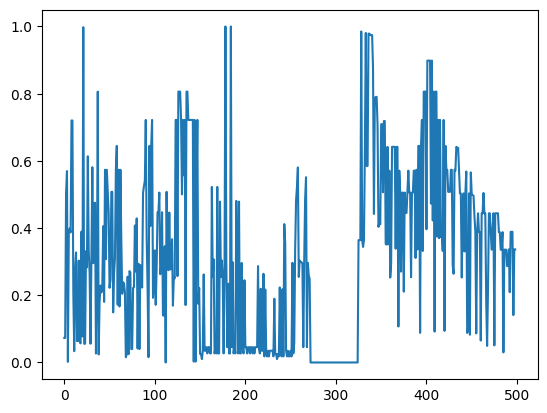

In [301]:
# we can plot the conservation score
plt.plot(subset_cs)